# Carlini Wagner Attacks

In [1]:
import xlab # for testing your code
xlab.hello_world()

from robustbench.utils import load_model
from robustbench.data import load_cifar10

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import matplotlib.pyplot as plt
from autoattack import AutoAttack
# import torchattacks
import pickle
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

Hello world! You are using version 0.1.7 of the package


## Tasks 1-5: Writing the function $f(x + \delta)$

Recall that we will be using a loss to minimize the equation below.
$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$

The function $\mathcal{D}$ measures how different $x$ (the original image) is from $x + \delta$ where $\delta$ is the purtubations we are making to the image. In the original paper, Carlini and Wagner list seven of reasonable choices you could make for $f$. For brevity, you will only implement and compare 3 of them. 

Note that the equations below are presented slightly differently than in the original paper. They are all mathematically equivalent, but we have rewritten some for clarity. $Z_t(x)$ is the raw output of the model for class $t$ (no softmax, no tricks). 

<details>
<summary>⚠️ <b>Caution</b></summary>

In this section we will have you implement 3 out of the 7 choices for $f$. We encourage you to implement the other choices of $f$ from [the paper](https://arxiv.org/pdf/1608.04644) if you are interested. We will caution you however that there appears to be a sign error in equation #1. The correct equation with the right signs should be shown below. Cross Entropy here will be taken with $\log_2$ rather than $\log_e$.

$$
f_1(x_{\mathrm{adversarial}}) = \mathrm{CrossEntropy}(F(x_{\mathrm{adversarial}})) - 1
$$

In general we find that the "Objective Function" section of the paper isn't very well written. For example they say that they "define an objective function $f$ such that $C(x + \delta) = t$ if and only if $f(x + \delta) \leq 0$." but it is trivial to show that equation 4 does not satisfy this property.

</details>

### Task #1: Implementing $f_2$

The one thing you have to be careful about is the first term in this equation takes the greatest softmax probability that is not the target class. The reason this works is that the model will only predict class $t$ if the sofmax probability for it is greater than any other class.

The equation for $f_2$ is below. $F_t(x)$ is the model output for class $t$ including the [softmax](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) which gives probabilities rather than logits. 

$$
f_2(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(F(x_{\mathrm{adversarial}})) - F_t(x_{\mathrm{adversarial}}))
$$

In [214]:
def f2(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(softmax_probs)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([softmax_probs[:target], softmax_probs[target+1:]]))
    return F.relu(softmax_probs[i_neq_t] - softmax_probs[target])

In [215]:
x = torch.tensor([1.0, 3.0])
print(f2(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f2(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f2(x, 0)) # should be =0

tensor(0.7616)
tensor(0.)
tensor(0.)


### Task #2: Implementing $f_4$

This is similar to the equation above. The only difference is that we are inforcing the requirement that the target class has a probability greater than or equal to 0.5 rather a probability greater than or equal to any of the other classes.

$$
f_4(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(0.5 - F_t(x_{\mathrm{adversarial}}))
$$

In [216]:
def f4(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    return F.relu(0.5 - softmax_probs[target])

In [217]:
x = torch.tensor([1.0, 3.0])
print(f4(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f4(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f4(x, 0)) # should be =0

tensor(0.3808)
tensor(0.)
tensor(0.)


### Task #3: Implementing $f_6$

$$
f_6(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(Z(x_{\mathrm{adversarial}})) - Z_t(x_{\mathrm{adversarial}}))
$$

In [242]:
def f6(logits, target):
    # softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    return F.relu(logits[i_neq_t] - logits[target])

In [243]:
x = torch.tensor([1.0, 3.0])
print(f6(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f6(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f6(x, 0)) # should be =0

tensor(2.)
tensor(0.)
tensor(0.)


By now you should have several options for $f$. Now we can optimize the below equation below where we let $\mathcal{D}(x, x + \delta)$ be the $L_2$ norm.

$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$

In [277]:
def cw_loss_v1(f, x, y, delta, c, model):
    logits = model(x + delta)
    f_loss = f(logits[0], y)
    norm_loss = torch.sum(delta**2)

    return norm_loss + c * f_loss

def cw_simple(f, x, y, c, model, num_iters):
    delta = torch.zeros_like(x)
    delta.requires_grad = True
    optimizer = optim.Adam([delta], lr=1e-3)

    for i in range(num_iters):
        l = cw_loss_v1(f, x, y, delta, c, model)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 20 == 0:
            print(f"iteration {i + 1}:\t loss={l.item():.4f}")
    return x + delta

# cw_simple(f, x, y, c, model, num_iters):

In [278]:
model(x_test[0:1])

tensor([[-2.6923, -0.9499, -1.3762, 16.3327, -3.2198, -0.0339, -0.1381, -2.5648,
         -1.4476, -3.8102]], device='mps:0', grad_fn=<LinearBackward0>)

In [279]:
torch.argmax(model(x_test[0:1]))

tensor(3, device='mps:0')

In [285]:
adv.shape

torch.Size([1, 3, 32, 32])

In [292]:
adv = cw_simple(f6, x_test[0:1], 0, 0.01, model, 100)

iteration 20:	 loss=0.0977
iteration 40:	 loss=0.0577
iteration 60:	 loss=0.0442
iteration 80:	 loss=0.0442
iteration 100:	 loss=0.0430


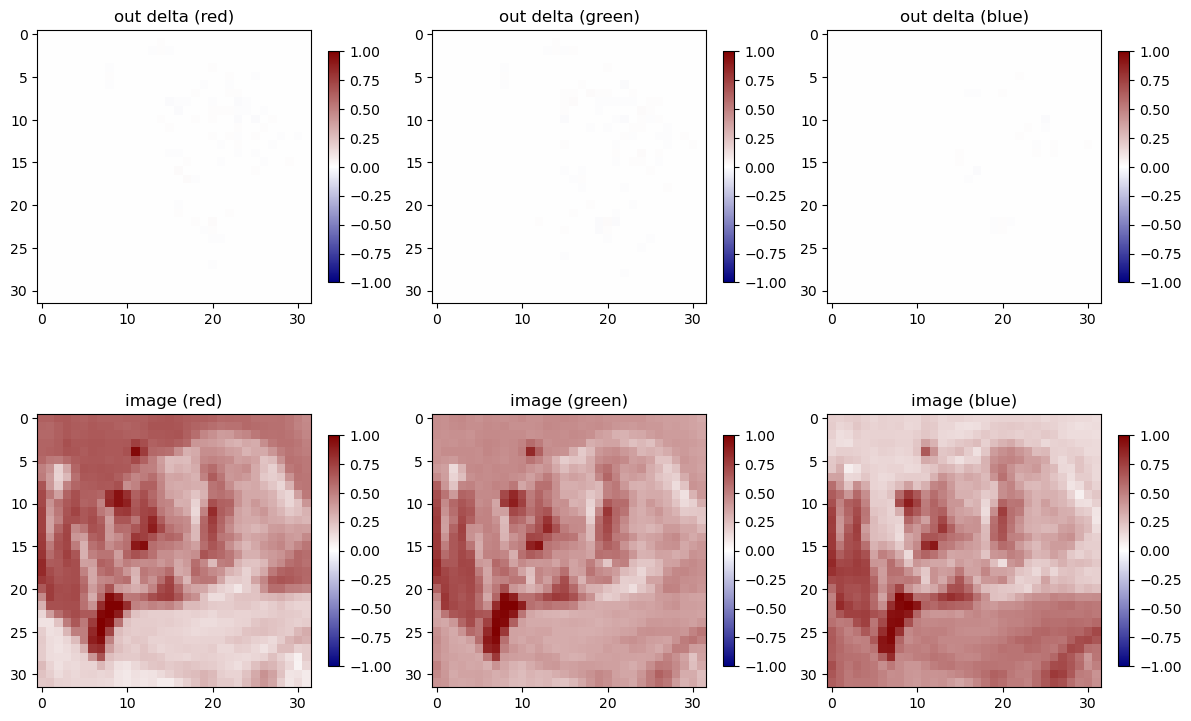

In [293]:
adv = adv[0].detach().cpu()
x = x_test[0].detach().cpu()
delta = adv - x

_ = xlab.utils.plot_tensors(
    [delta[0], delta[1], delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

In [282]:
torch.argmax(model(adv))

tensor(0, device='mps:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050887734..1.0007143].


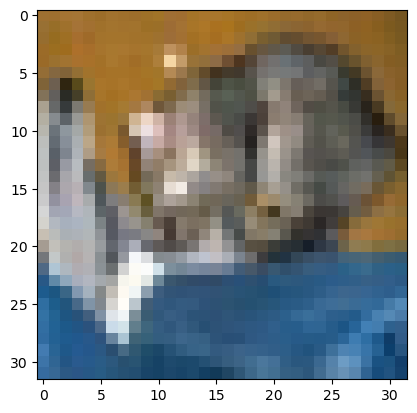

In [283]:
plt.imshow(adv[0].detach().cpu().permute(1,2,0))

In [ ]:
F.cross_entropy(torch.tensor([1.0, 2, 3]), torch.tensor(1))

In [135]:
torch.log(F.softmax(torch.tensor([1.0, 2, 3]), dim=0))

tensor([-2.4076, -1.4076, -0.4076])

$$
f_1(x_{\mathrm{adversarial}}) = -C(F(x_{\mathrm{adversarial}})) + 1
$$

In [2]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


In [4]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


In [119]:
def f_6(logits, target, k=0):
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    print("in f6", (logits[i_neq_t] - logits[target]).item())
    return torch.max(logits[i_neq_t] - logits[target], torch.tensor(k))
            

def CW_targeted_l2(img, model, c, target, k=0.1):
    
    cw_weights = torch.randn_like(img, requires_grad=True).to('mps')
    optimizer = optim.Adam([cw_weights], lr=1e-1)

    num_iters = 200
    delta = 0.5 * (F.tanh(cw_weights) + 1) - img

    k = 0.1

    for i in range(num_iters):
        
        logits = model((img + delta).unsqueeze(0))

        if torch.argmax(logits[0]) == target and torch.max(torch.abs(delta)) < 8/255:
            return delta

        # print(f_6(logits[0], target))
        assert f_6(logits[0], target, k) >= k
        success_loss = c * f_6(logits[0], target, k)
        l2_reg = torch.sum((delta)**2)

        loss = success_loss + l2_reg
        print(loss, success_loss, l2_reg)
        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        

        delta = 0.5 * (F.tanh(cw_weights) + 1) - img
    print("warning! targeted attack was not successful")
    return delta

In [120]:
torch.max(torch.tensor(5), torch.tensor(-2))

tensor(5)

In [121]:
x = x_test[0]

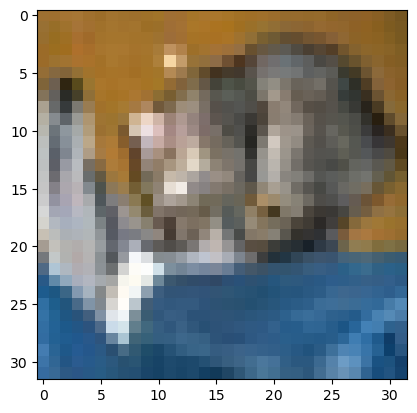

In [122]:
plt.imshow(x.permute(1,2,0).cpu())

In [123]:
out_delta = CW_targeted_l2(x.to('mps'), model, 0.003, 0)

in f6 11.917903900146484
in f6 11.917903900146484
tensor(439.3732, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0358, device='mps:0', grad_fn=<MulBackward0>) tensor(439.3374, device='mps:0', grad_fn=<SumBackward0>)
in f6 12.267534255981445
in f6 12.267534255981445
tensor(392.7876, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0368, device='mps:0', grad_fn=<MulBackward0>) tensor(392.7508, device='mps:0', grad_fn=<SumBackward0>)
in f6 12.506669998168945
in f6 12.506669998168945
tensor(349.0219, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0375, device='mps:0', grad_fn=<MulBackward0>) tensor(348.9844, device='mps:0', grad_fn=<SumBackward0>)
in f6 12.746418952941895
in f6 12.746418952941895
tensor(308.5363, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0382, device='mps:0', grad_fn=<MulBackward0>) tensor(308.4981, device='mps:0', grad_fn=<SumBackward0>)
in f6 12.962756156921387
in f6 12.962756156921387
tensor(271.2489, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0389, de

In [124]:
out_delta.shape

torch.Size([3, 32, 32])

In [125]:
8/255

0.03137254901960784

In [126]:
out_delta.min(), out_delta.max()

(tensor(-0.0292, device='mps:0', grad_fn=<MinBackward1>),
 tensor(0.0312, device='mps:0', grad_fn=<MaxBackward1>))

In [127]:
max_diff = torch.max(torch.abs(out_delta))

In [128]:
assert max_diff < 8/255

Now let's plot what we have. You should 

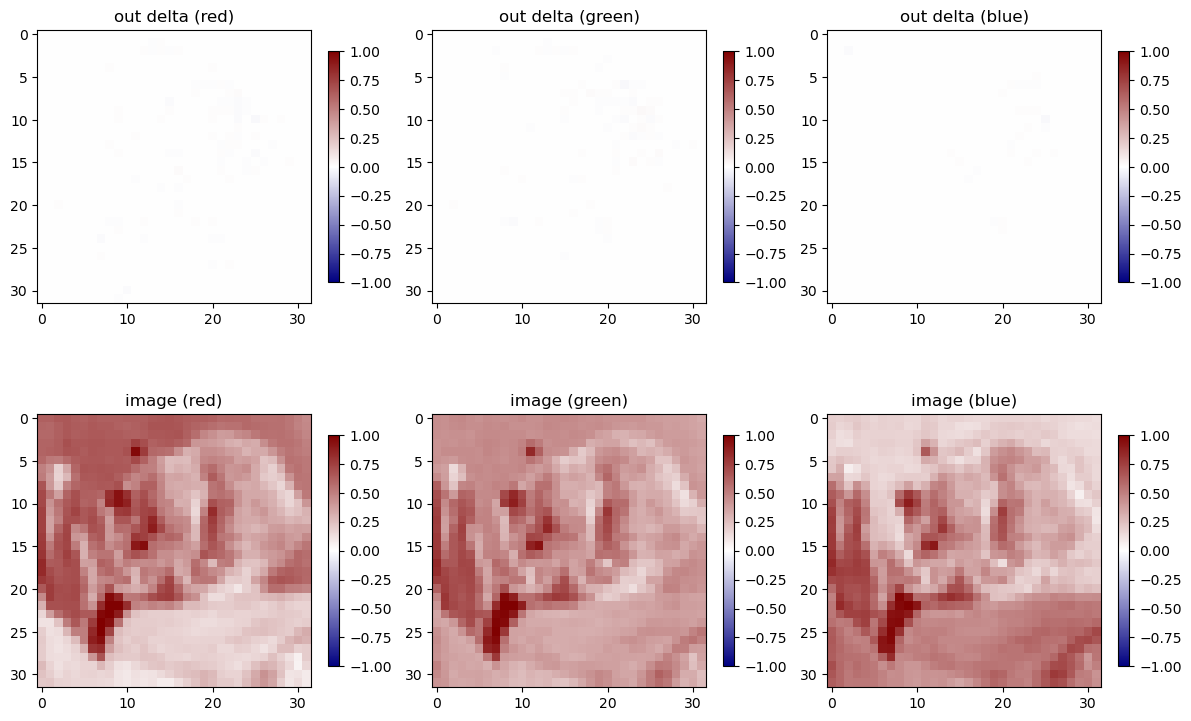

In [129]:
out_delta = out_delta.detach().cpu()

_ = xlab.utils.plot_tensors(
    [out_delta[0], out_delta[1], out_delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

In [43]:
x_adv = out_delta + x

In [44]:
model(x_adv.unsqueeze(0))

tensor([[13.4251, -0.7176, -1.3678,  3.0889, -5.2713, -1.6484, -1.6464, -2.5078,
         -1.8055, -1.4932]], device='mps:0', grad_fn=<LinearBackward0>)

In [45]:
x_adv.shape

torch.Size([3, 32, 32])

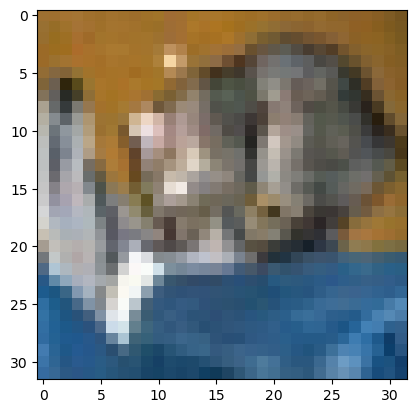

In [46]:
plt.imshow(x_adv.detach().permute(1,2,0).cpu())

## Choosing a constant $c$


<blockquote>
    Empirically, we have found that often the best way to choose
$c$ is to use the smallest value of $c$ for which the resulting
solution $x^{*}$ has $f(x^{*}
)\leq 0$. This causes gradient descent to
minimize both of the terms simultaneously instead of picking
only one to optimize over first.
</blockquote>



On choosing a good $f$:

<blockquote>
The choice of method
for handling box constraints does not impact the quality of
results as significantly for the best minimization functions.
</blockquote>